In [5]:
import torchvision.transforms as transforms
import torch, os, cv2
import torch.nn as nn
import torchvision.transforms as T
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU') if str(device) == "cuda:0" else print('GPU not Detected - CPU Selected')
print(f"GPUs Count: {torch.cuda.device_count()}")

GPU
GPUs Count: 1


### **Preparation of Data Loaders**

In [6]:
my_batch_size = 64

In [7]:
class DensePointsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.png'))])
        self.mask_files = sorted([f for f in os.listdir(masks_dir) if f.lower().endswith(('.png'))])
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()    # Ensure mask is binary (0 or 1)
        return image, mask

image_transform = transforms.Compose([transforms.CenterCrop((480, 480)), transforms.ToTensor()])
mask_transform = T.Compose([T.CenterCrop((480, 480)), T.ToTensor()])

train_imgs = "./TRAINING_DATA/Training_Set"          # Provide Correct Path to Data
train_masks = "./TRAINING_DATA/Training_Labels"      # Provide Correct Path to Data

val_imgs = "./TRAINING_DATA/Validation_Set"          # Provide Correct Path to Data
val_masks = "./TRAINING_DATA/Validation_Labels"      # Provide Correct Path to Data

train_dataset = DensePointsDataset(images_dir=train_imgs, masks_dir=train_masks, transform=image_transform, mask_transform=mask_transform)
val_dataset = DensePointsDataset(images_dir=val_imgs, masks_dir=val_masks, transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=my_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=my_batch_size, shuffle=False, num_workers=2)

#### **ESPNet Model**

In [8]:
'''
### Code Reference: https://github.com/sacmehta/ESPNet
'''

class CBR(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride=1):
        super().__init__()
        padding = int((kSize - 1)/2)
        self.conv = nn.Conv2d(nIn, nOut, (kSize, kSize), stride=stride, padding=(padding, padding), bias=False)
        self.bn = nn.BatchNorm2d(nOut, eps=1e-03)
        self.act = nn.PReLU(nOut)

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.act(output)
        return output

class BR(nn.Module):
    def __init__(self, nOut):
        super().__init__()
        self.bn = nn.BatchNorm2d(nOut, eps=1e-03)
        self.act = nn.PReLU(nOut)

    def forward(self, input):
        output = self.bn(input)
        output = self.act(output)
        return output

class CB(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride=1):
        super().__init__()
        padding = int((kSize - 1)/2)
        self.conv = nn.Conv2d(nIn, nOut, (kSize, kSize), stride=stride, padding=(padding, padding), bias=False)
        self.bn = nn.BatchNorm2d(nOut, eps=1e-03)

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        return output

class C(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride=1):
        super().__init__()
        padding = int((kSize - 1)/2)
        self.conv = nn.Conv2d(nIn, nOut, (kSize, kSize), stride=stride, padding=(padding, padding), bias=False)

    def forward(self, input):
        output = self.conv(input)
        return output

class CDilated(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride=1, d=1):
        super().__init__()
        padding = int((kSize - 1)/2) * d
        self.conv = nn.Conv2d(nIn, nOut, (kSize, kSize), stride=stride, padding=(padding, padding), bias=False, dilation=d)

    def forward(self, input):
        output = self.conv(input)
        return output

class DownSamplerB(nn.Module):
    def __init__(self, nIn, nOut):
        super().__init__()
        n = int(nOut/5)
        n1 = nOut - 4*n
        self.c1 = C(nIn, n, 3, 2)
        self.d1 = CDilated(n, n1, 3, 1, 1)
        self.d2 = CDilated(n, n, 3, 1, 2)
        self.d4 = CDilated(n, n, 3, 1, 4)
        self.d8 = CDilated(n, n, 3, 1, 8)
        self.d16 = CDilated(n, n, 3, 1, 16)
        self.bn = nn.BatchNorm2d(nOut, eps=1e-3)
        self.act = nn.PReLU(nOut)

    def forward(self, input):
        output1 = self.c1(input)
        d1 = self.d1(output1)
        d2 = self.d2(output1)
        d4 = self.d4(output1)
        d8 = self.d8(output1)
        d16 = self.d16(output1)
        add1 = d2
        add2 = add1 + d4
        add3 = add2 + d8
        add4 = add3 + d16
        combine = torch.cat([d1, add1, add2, add3, add4],1)
        output = self.bn(combine)
        output = self.act(output)
        return output

class DilatedParllelResidualBlockB(nn.Module):
    def __init__(self, nIn, nOut, add=True):
        super().__init__()
        n = int(nOut/5)
        n1 = nOut - 4*n
        self.c1 = C(nIn, n, 1, 1)
        self.d1 = CDilated(n, n1, 3, 1, 1)  # dilation rate of 2^0
        self.d2 = CDilated(n, n, 3, 1, 2)   # dilation rate of 2^1
        self.d4 = CDilated(n, n, 3, 1, 4)   # dilation rate of 2^2
        self.d8 = CDilated(n, n, 3, 1, 8)   # dilation rate of 2^3
        self.d16 = CDilated(n, n, 3, 1, 16) # dilation rate of 2^4
        self.bn = BR(nOut)
        self.add = add

    def forward(self, input):
        output1 = self.c1(input)
        d1 = self.d1(output1)
        d2 = self.d2(output1)
        d4 = self.d4(output1)
        d8 = self.d8(output1)
        d16 = self.d16(output1)
        add1 = d2
        add2 = add1 + d4
        add3 = add2 + d8
        add4 = add3 + d16
        combine = torch.cat([d1, add1, add2, add3, add4], 1)
        if self.add:
            combine = input + combine
        output = self.bn(combine)
        return output

class InputProjectionA(nn.Module):
    def __init__(self, samplingTimes):
        super().__init__()
        self.pool = nn.ModuleList()
        for i in range(0, samplingTimes):
            self.pool.append(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, input):
        for pool in self.pool:
            input = pool(input)
        return input

class ESPNet_Encoder(nn.Module):
    def __init__(self, channels, p, q):
        super().__init__()
        self.level1 = CBR(3, 16, 3, 2)
        self.sample1 = InputProjectionA(1)
        self.sample2 = InputProjectionA(2)
        self.b1 = BR(16 + 3)
        self.level2_0 = DownSamplerB(16 + 3, 64)
        self.level2 = nn.ModuleList()
        for i in range(0, p):
            self.level2.append(DilatedParllelResidualBlockB(64 , 64))
        self.b2 = BR(128 + 3)
        self.level3_0 = DownSamplerB(128 + 3, 128)
        self.level3 = nn.ModuleList()
        for i in range(0, q):
            self.level3.append(DilatedParllelResidualBlockB(128 , 128))
        self.b3 = BR(256)
        self.classifier = C(256, channels, 1, 1)

    def forward(self, input):
        output0 = self.level1(input)
        inp1 = self.sample1(input)
        inp2 = self.sample2(input)
        output0_cat = self.b1(torch.cat([output0, inp1], 1))
        output1_0 = self.level2_0(output0_cat)
        
        for i, layer in enumerate(self.level2):
            if i==0:
                output1 = layer(output1_0)
            else:
                output1 = layer(output1)

        output1_cat = self.b2(torch.cat([output1,  output1_0, inp2], 1))
        output2_0 = self.level3_0(output1_cat)
        for i, layer in enumerate(self.level3):
            if i==0:
                output2 = layer(output2_0)
            else:
                output2 = layer(output2)
        output2_cat = self.b3(torch.cat([output2_0, output2], 1))
        classifier = self.classifier(output2_cat)
        return classifier
        
class ESPNet(nn.Module):
    def __init__(self, channels=10, final_class=1, p=5, q=9):
        super().__init__()
        self.encoder = ESPNet_Encoder(channels, p, q)
        self.modules = []
        for i, m in enumerate(self.encoder.children()):
            self.modules.append(m)

        self.level3_C = C(128 + 3, channels, 1, 1)
        self.br = nn.BatchNorm2d(channels, eps=1e-03)
        self.conv = CBR(19 + channels, channels, 3, 1)
        self.up_l3 = nn.Sequential(nn.ConvTranspose2d(channels, channels, 2, stride=2, padding=0, output_padding=0, bias=False))
        self.combine_l2_l3 = nn.Sequential(BR(2*channels), DilatedParllelResidualBlockB(2*channels , channels, add=False))
        self.up_l2 = nn.Sequential(nn.ConvTranspose2d(channels, channels, 2, stride=2, padding=0, output_padding=0, bias=False), BR(channels))
        self.classifier = nn.ConvTranspose2d(channels, final_class, 2, stride=2, padding=0, output_padding=0, bias=False)

    def forward(self, input):
        output0 = self.modules[0](input)
        inp1 = self.modules[1](input)
        inp2 = self.modules[2](input)

        output0_cat = self.modules[3](torch.cat([output0, inp1], 1))
        output1_0 = self.modules[4](output0_cat)
        for i, layer in enumerate(self.modules[5]):
            if i == 0:
                output1 = layer(output1_0)
            else:
                output1 = layer(output1)

        output1_cat = self.modules[6](torch.cat([output1, output1_0, inp2], 1))
        output2_0 = self.modules[7](output1_cat)
        for i, layer in enumerate(self.modules[8]):
            if i == 0:
                output2 = layer(output2_0)
            else:
                output2 = layer(output2)

        output2_cat = self.modules[9](torch.cat([output2_0, output2], 1))
        output2_c = self.up_l3(self.br(self.modules[10](output2_cat)))
        output1_C = self.level3_C(output1_cat)
        comb_l2_l3 = self.up_l2(self.combine_l2_l3(torch.cat([output1_C, output2_c], 1)))
        concat_features = self.conv(torch.cat([comb_l2_l3, output0_cat], 1))
        classifier = self.classifier(concat_features)
        return classifier

model = ESPNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### **Training and Validation**

In [ ]:
num_epochs = 100
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min = 0.000001)   # or 0.00001

best_val_loss = float("inf")
train_losses, val_losses, train_losses_bw, val_losses_bw = [], [], [], []

########################################################### TRAINING
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_losses_bw.append(loss.item())
        loop.set_postfix(loss=loss.item())  # for tqdm
        
    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} --- Train Loss: {avg_train_loss:.4f}")

    ########################################################### VALIDATION
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_losses_bw.append(loss.item())
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"*** Validation:   Train Loss: {avg_train_loss:.4f} --- Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, "DEEP_DETECT_Best_Model.pth")
        print(f"Model saved with BEST val loss {best_val_loss:.4f}")

Epoch [1/100]: 100%|██████████| 516/516 [02:16<00:00,  3.78it/s, loss=0.218]

Epoch 1/100 --- Train Loss: 0.3066


*** Validation:   Train Loss: 0.3066 --- Val Loss: 0.1967
Model saved with BEST val loss 0.1967


Epoch [2/100]: 100%|██████████| 516/516 [02:13<00:00,  3.86it/s, loss=0.209]

Epoch 2/100 --- Train Loss: 0.1988


*** Validation:   Train Loss: 0.1988 --- Val Loss: 0.1702
Model saved with BEST val loss 0.1702


Epoch [3/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.18] 

Epoch 3/100 --- Train Loss: 0.1794


*** Validation:   Train Loss: 0.1794 --- Val Loss: 0.1558
Model saved with BEST val loss 0.1558


Epoch [4/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.177]

Epoch 4/100 --- Train Loss: 0.1697


*** Validation:   Train Loss: 0.1697 --- Val Loss: 0.1536
Model saved with BEST val loss 0.1536


Epoch [5/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.163]

Epoch 5/100 --- Train Loss: 0.1637


*** Validation:   Train Loss: 0.1637 --- Val Loss: 0.1463
Model saved with BEST val loss 0.1463


Epoch [6/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.164]

Epoch 6/100 --- Train Loss: 0.1598


*** Validation:   Train Loss: 0.1598 --- Val Loss: 0.1471


Epoch [7/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.156]

Epoch 7/100 --- Train Loss: 0.1558


*** Validation:   Train Loss: 0.1558 --- Val Loss: 0.1390
Model saved with BEST val loss 0.1390


Epoch [8/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.149]

Epoch 8/100 --- Train Loss: 0.1541


*** Validation:   Train Loss: 0.1541 --- Val Loss: 0.1394


Epoch [9/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.167]

Epoch 9/100 --- Train Loss: 0.1513


*** Validation:   Train Loss: 0.1513 --- Val Loss: 0.1350
Model saved with BEST val loss 0.1350


Epoch [10/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.134]

Epoch 10/100 --- Train Loss: 0.1508


*** Validation:   Train Loss: 0.1508 --- Val Loss: 0.1345
Model saved with BEST val loss 0.1345


Epoch [11/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.141]

Epoch 11/100 --- Train Loss: 0.1489


*** Validation:   Train Loss: 0.1489 --- Val Loss: 0.1334
Model saved with BEST val loss 0.1334


Epoch [12/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.157]

Epoch 12/100 --- Train Loss: 0.1467


*** Validation:   Train Loss: 0.1467 --- Val Loss: 0.1335


Epoch [13/100]: 100%|██████████| 516/516 [02:13<00:00,  3.85it/s, loss=0.146]

Epoch 13/100 --- Train Loss: 0.1460


*** Validation:   Train Loss: 0.1460 --- Val Loss: 0.1315
Model saved with BEST val loss 0.1315


Epoch [14/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.131]

Epoch 14/100 --- Train Loss: 0.1448


*** Validation:   Train Loss: 0.1448 --- Val Loss: 0.1316


Epoch [15/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.209]

Epoch 15/100 --- Train Loss: 0.1439


*** Validation:   Train Loss: 0.1439 --- Val Loss: 0.1496


Epoch [16/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.129]

Epoch 16/100 --- Train Loss: 0.1432


*** Validation:   Train Loss: 0.1432 --- Val Loss: 0.1328


Epoch [17/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.136]

Epoch 17/100 --- Train Loss: 0.1427


*** Validation:   Train Loss: 0.1427 --- Val Loss: 0.1306
Model saved with BEST val loss 0.1306


Epoch [18/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.141]

Epoch 18/100 --- Train Loss: 0.1409


*** Validation:   Train Loss: 0.1409 --- Val Loss: 0.1287
Model saved with BEST val loss 0.1287


Epoch [19/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.139]

Epoch 19/100 --- Train Loss: 0.1403


*** Validation:   Train Loss: 0.1403 --- Val Loss: 0.1295


Epoch [20/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.125]

Epoch 20/100 --- Train Loss: 0.1404


*** Validation:   Train Loss: 0.1404 --- Val Loss: 0.1290


Epoch [21/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.13] 

Epoch 21/100 --- Train Loss: 0.1391


*** Validation:   Train Loss: 0.1391 --- Val Loss: 0.1280
Model saved with BEST val loss 0.1280


Epoch [22/100]: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s, loss=0.156]

Epoch 22/100 --- Train Loss: 0.1388


*** Validation:   Train Loss: 0.1388 --- Val Loss: 0.1288


Epoch [23/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.132]

Epoch 23/100 --- Train Loss: 0.1378


*** Validation:   Train Loss: 0.1378 --- Val Loss: 0.1318


Epoch [24/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.146]

Epoch 24/100 --- Train Loss: 0.1373


*** Validation:   Train Loss: 0.1373 --- Val Loss: 0.1272
Model saved with BEST val loss 0.1272


Epoch [25/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.132]

Epoch 25/100 --- Train Loss: 0.1366


*** Validation:   Train Loss: 0.1366 --- Val Loss: 0.1235
Model saved with BEST val loss 0.1235


Epoch [26/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.129]

Epoch 26/100 --- Train Loss: 0.1360


*** Validation:   Train Loss: 0.1360 --- Val Loss: 0.1265


Epoch [27/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.141]

Epoch 27/100 --- Train Loss: 0.1364


*** Validation:   Train Loss: 0.1364 --- Val Loss: 0.1261


Epoch [28/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.127]

Epoch 28/100 --- Train Loss: 0.1356


*** Validation:   Train Loss: 0.1356 --- Val Loss: 0.1265


Epoch [29/100]: 100%|██████████| 516/516 [02:14<00:00,  3.84it/s, loss=0.143]

Epoch 29/100 --- Train Loss: 0.1346


*** Validation:   Train Loss: 0.1346 --- Val Loss: 0.1242


Epoch [30/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.15] 

Epoch 30/100 --- Train Loss: 0.1339


*** Validation:   Train Loss: 0.1339 --- Val Loss: 0.1243


Epoch [31/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.147]

Epoch 31/100 --- Train Loss: 0.1340


*** Validation:   Train Loss: 0.1340 --- Val Loss: 0.1224
Model saved with BEST val loss 0.1224


Epoch [32/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.123]

Epoch 32/100 --- Train Loss: 0.1336


*** Validation:   Train Loss: 0.1336 --- Val Loss: 0.1239


Epoch [33/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.138]

Epoch 33/100 --- Train Loss: 0.1330


*** Validation:   Train Loss: 0.1330 --- Val Loss: 0.1229


Epoch [34/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.122]

Epoch 34/100 --- Train Loss: 0.1329


*** Validation:   Train Loss: 0.1329 --- Val Loss: 0.1240


Epoch [35/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.133]

Epoch 35/100 --- Train Loss: 0.1328


*** Validation:   Train Loss: 0.1328 --- Val Loss: 0.1219
Model saved with BEST val loss 0.1219


Epoch [36/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.134]

Epoch 36/100 --- Train Loss: 0.1318


*** Validation:   Train Loss: 0.1318 --- Val Loss: 0.1218
Model saved with BEST val loss 0.1218


Epoch [37/100]: 100%|██████████| 516/516 [02:11<00:00,  3.91it/s, loss=0.131]

Epoch 37/100 --- Train Loss: 0.1313


*** Validation:   Train Loss: 0.1313 --- Val Loss: 0.1228


Epoch [38/100]: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s, loss=0.139]

Epoch 38/100 --- Train Loss: 0.1313


*** Validation:   Train Loss: 0.1313 --- Val Loss: 0.1243


Epoch [39/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.138]

Epoch 39/100 --- Train Loss: 0.1310


*** Validation:   Train Loss: 0.1310 --- Val Loss: 0.1208
Model saved with BEST val loss 0.1208


Epoch [40/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.116]

Epoch 40/100 --- Train Loss: 0.1308


*** Validation:   Train Loss: 0.1308 --- Val Loss: 0.1227


Epoch [41/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.132]

Epoch 41/100 --- Train Loss: 0.1305


*** Validation:   Train Loss: 0.1305 --- Val Loss: 0.1202
Model saved with BEST val loss 0.1202


Epoch [42/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.133]

Epoch 42/100 --- Train Loss: 0.1299


*** Validation:   Train Loss: 0.1299 --- Val Loss: 0.1248


Epoch [43/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.132]

Epoch 43/100 --- Train Loss: 0.1297


*** Validation:   Train Loss: 0.1297 --- Val Loss: 0.1197
Model saved with BEST val loss 0.1197


Epoch [44/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.123]

Epoch 44/100 --- Train Loss: 0.1293


*** Validation:   Train Loss: 0.1293 --- Val Loss: 0.1197
Model saved with BEST val loss 0.1197


Epoch [45/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.134]

Epoch 45/100 --- Train Loss: 0.1289


*** Validation:   Train Loss: 0.1289 --- Val Loss: 0.1195
Model saved with BEST val loss 0.1195


Epoch [46/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.122]

Epoch 46/100 --- Train Loss: 0.1284


*** Validation:   Train Loss: 0.1284 --- Val Loss: 0.1195
Model saved with BEST val loss 0.1195


Epoch [47/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.126]

Epoch 47/100 --- Train Loss: 0.1279


*** Validation:   Train Loss: 0.1279 --- Val Loss: 0.1184
Model saved with BEST val loss 0.1184


Epoch [48/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.115]

Epoch 48/100 --- Train Loss: 0.1279


*** Validation:   Train Loss: 0.1279 --- Val Loss: 0.1191


Epoch [49/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.119]

Epoch 49/100 --- Train Loss: 0.1270


*** Validation:   Train Loss: 0.1270 --- Val Loss: 0.1189


Epoch [50/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.12] 

Epoch 50/100 --- Train Loss: 0.1273


*** Validation:   Train Loss: 0.1273 --- Val Loss: 0.1178
Model saved with BEST val loss 0.1178


Epoch [51/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.122]

Epoch 51/100 --- Train Loss: 0.1273


*** Validation:   Train Loss: 0.1273 --- Val Loss: 0.1180


Epoch [52/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.126]

Epoch 52/100 --- Train Loss: 0.1272


*** Validation:   Train Loss: 0.1272 --- Val Loss: 0.1192


Epoch [53/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.138]

Epoch 53/100 --- Train Loss: 0.1265


*** Validation:   Train Loss: 0.1265 --- Val Loss: 0.1202


Epoch [54/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.121]

Epoch 54/100 --- Train Loss: 0.1262


*** Validation:   Train Loss: 0.1262 --- Val Loss: 0.1180


Epoch [55/100]: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s, loss=0.127]

Epoch 55/100 --- Train Loss: 0.1260


*** Validation:   Train Loss: 0.1260 --- Val Loss: 0.1177
Model saved with BEST val loss 0.1177


Epoch [56/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.121]

Epoch 56/100 --- Train Loss: 0.1257


*** Validation:   Train Loss: 0.1257 --- Val Loss: 0.1173
Model saved with BEST val loss 0.1173


Epoch [57/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.131]

Epoch 57/100 --- Train Loss: 0.1258


*** Validation:   Train Loss: 0.1258 --- Val Loss: 0.1180


Epoch [58/100]: 100%|██████████| 516/516 [02:13<00:00,  3.88it/s, loss=0.12] 

Epoch 58/100 --- Train Loss: 0.1253


*** Validation:   Train Loss: 0.1253 --- Val Loss: 0.1171
Model saved with BEST val loss 0.1171


Epoch [59/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.137]

Epoch 59/100 --- Train Loss: 0.1252


*** Validation:   Train Loss: 0.1252 --- Val Loss: 0.1167
Model saved with BEST val loss 0.1167


Epoch [60/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.124]

Epoch 60/100 --- Train Loss: 0.1249


*** Validation:   Train Loss: 0.1249 --- Val Loss: 0.1183


Epoch [61/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.129]

Epoch 61/100 --- Train Loss: 0.1245


*** Validation:   Train Loss: 0.1245 --- Val Loss: 0.1164
Model saved with BEST val loss 0.1164


Epoch [62/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.128]

Epoch 62/100 --- Train Loss: 0.1245


*** Validation:   Train Loss: 0.1245 --- Val Loss: 0.1162
Model saved with BEST val loss 0.1162


Epoch [63/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.139]

Epoch 63/100 --- Train Loss: 0.1246


*** Validation:   Train Loss: 0.1246 --- Val Loss: 0.1160
Model saved with BEST val loss 0.1160


Epoch [64/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.131]

Epoch 64/100 --- Train Loss: 0.1242


*** Validation:   Train Loss: 0.1242 --- Val Loss: 0.1215


Epoch [65/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.113]

Epoch 65/100 --- Train Loss: 0.1239


*** Validation:   Train Loss: 0.1239 --- Val Loss: 0.1160
Model saved with BEST val loss 0.1160


Epoch [66/100]: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s, loss=0.121]

Epoch 66/100 --- Train Loss: 0.1237


*** Validation:   Train Loss: 0.1237 --- Val Loss: 0.1158
Model saved with BEST val loss 0.1158


Epoch [67/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.117]

Epoch 67/100 --- Train Loss: 0.1235


*** Validation:   Train Loss: 0.1235 --- Val Loss: 0.1168


Epoch [68/100]: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s, loss=0.128]

Epoch 68/100 --- Train Loss: 0.1234


*** Validation:   Train Loss: 0.1234 --- Val Loss: 0.1157
Model saved with BEST val loss 0.1157


Epoch [69/100]: 100%|██████████| 516/516 [02:13<00:00,  3.88it/s, loss=0.124]

Epoch 69/100 --- Train Loss: 0.1232


*** Validation:   Train Loss: 0.1232 --- Val Loss: 0.1161


Epoch [70/100]: 100%|██████████| 516/516 [02:13<00:00,  3.88it/s, loss=0.116]

Epoch 70/100 --- Train Loss: 0.1231


*** Validation:   Train Loss: 0.1231 --- Val Loss: 0.1155
Model saved with BEST val loss 0.1155


Epoch [71/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.131]

Epoch 71/100 --- Train Loss: 0.1231


*** Validation:   Train Loss: 0.1231 --- Val Loss: 0.1153
Model saved with BEST val loss 0.1153


Epoch [72/100]: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s, loss=0.133]

Epoch 72/100 --- Train Loss: 0.1228


*** Validation:   Train Loss: 0.1228 --- Val Loss: 0.1151
Model saved with BEST val loss 0.1151


Epoch [73/100]: 100%|██████████| 516/516 [02:13<00:00,  3.88it/s, loss=0.128]

Epoch 73/100 --- Train Loss: 0.1227


*** Validation:   Train Loss: 0.1227 --- Val Loss: 0.1156


Epoch [74/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.134] 

Epoch 74/100 --- Train Loss: 0.1225


*** Validation:   Train Loss: 0.1225 --- Val Loss: 0.1150
Model saved with BEST val loss 0.1150


Epoch [75/100]: 100%|██████████| 516/516 [02:13<00:00,  3.88it/s, loss=0.121] 

Epoch 75/100 --- Train Loss: 0.1225


*** Validation:   Train Loss: 0.1225 --- Val Loss: 0.1151


Epoch [76/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.134]

Epoch 76/100 --- Train Loss: 0.1223


*** Validation:   Train Loss: 0.1223 --- Val Loss: 0.1149
Model saved with BEST val loss 0.1149


Epoch [77/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.113]

Epoch 77/100 --- Train Loss: 0.1221


*** Validation:   Train Loss: 0.1221 --- Val Loss: 0.1149


Epoch [78/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.142]

Epoch 78/100 --- Train Loss: 0.1221


*** Validation:   Train Loss: 0.1221 --- Val Loss: 0.1149


Epoch [79/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.111]

Epoch 79/100 --- Train Loss: 0.1220


*** Validation:   Train Loss: 0.1220 --- Val Loss: 0.1153


Epoch [80/100]: 100%|██████████| 516/516 [02:12<00:00,  3.90it/s, loss=0.131]

Epoch 80/100 --- Train Loss: 0.1219


*** Validation:   Train Loss: 0.1219 --- Val Loss: 0.1152


Epoch [81/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.134]

Epoch 81/100 --- Train Loss: 0.1218


*** Validation:   Train Loss: 0.1218 --- Val Loss: 0.1147
Model saved with BEST val loss 0.1147


Epoch [82/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.129]

Epoch 82/100 --- Train Loss: 0.1217


*** Validation:   Train Loss: 0.1217 --- Val Loss: 0.1147


Epoch [83/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.12] 

Epoch 83/100 --- Train Loss: 0.1216


*** Validation:   Train Loss: 0.1216 --- Val Loss: 0.1146
Model saved with BEST val loss 0.1146


Epoch [84/100]: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s, loss=0.119]


Epoch 84/100 --- Train Loss: 0.1215
*** Validation:   Train Loss: 0.1215 --- Val Loss: 0.1147


Epoch [85/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.125]

Epoch 85/100 --- Train Loss: 0.1215


*** Validation:   Train Loss: 0.1215 --- Val Loss: 0.1151


Epoch [86/100]: 100%|██████████| 516/516 [02:13<00:00,  3.88it/s, loss=0.117]


Epoch 86/100 --- Train Loss: 0.1214
*** Validation:   Train Loss: 0.1214 --- Val Loss: 0.1146
Model saved with BEST val loss 0.1146


Epoch [87/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.116]

Epoch 87/100 --- Train Loss: 0.1214


*** Validation:   Train Loss: 0.1214 --- Val Loss: 0.1145
Model saved with BEST val loss 0.1145


Epoch [88/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.126]

Epoch 88/100 --- Train Loss: 0.1214


*** Validation:   Train Loss: 0.1214 --- Val Loss: 0.1146


Epoch [89/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.117]

Epoch 89/100 --- Train Loss: 0.1213


*** Validation:   Train Loss: 0.1213 --- Val Loss: 0.1145
Model saved with BEST val loss 0.1145


Epoch [90/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.107] 

Epoch 90/100 --- Train Loss: 0.1212


*** Validation:   Train Loss: 0.1212 --- Val Loss: 0.1144
Model saved with BEST val loss 0.1144


Epoch [91/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.112]

Epoch 91/100 --- Train Loss: 0.1212


*** Validation:   Train Loss: 0.1212 --- Val Loss: 0.1144
Model saved with BEST val loss 0.1144


Epoch [92/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.123]

Epoch 92/100 --- Train Loss: 0.1212


*** Validation:   Train Loss: 0.1212 --- Val Loss: 0.1144


Epoch [93/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.127]

Epoch 93/100 --- Train Loss: 0.1212


*** Validation:   Train Loss: 0.1212 --- Val Loss: 0.1144
Model saved with BEST val loss 0.1144


Epoch [94/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.119]

Epoch 94/100 --- Train Loss: 0.1211


*** Validation:   Train Loss: 0.1211 --- Val Loss: 0.1144


Epoch [95/100]: 100%|██████████| 516/516 [02:12<00:00,  3.89it/s, loss=0.126]

Epoch 95/100 --- Train Loss: 0.1211


*** Validation:   Train Loss: 0.1211 --- Val Loss: 0.1144


Epoch [96/100]: 100%|██████████| 516/516 [02:13<00:00,  3.88it/s, loss=0.132]

Epoch 96/100 --- Train Loss: 0.1210


*** Validation:   Train Loss: 0.1210 --- Val Loss: 0.1145


Epoch [97/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.142]

Epoch 97/100 --- Train Loss: 0.1211


*** Validation:   Train Loss: 0.1211 --- Val Loss: 0.1144


Epoch [98/100]: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s, loss=0.126]

Epoch 98/100 --- Train Loss: 0.1209


*** Validation:   Train Loss: 0.1209 --- Val Loss: 0.1144


Epoch [99/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.112]

Epoch 99/100 --- Train Loss: 0.1210


*** Validation:   Train Loss: 0.1210 --- Val Loss: 0.1144


Epoch [100/100]: 100%|██████████| 516/516 [02:12<00:00,  3.88it/s, loss=0.146]

Epoch 100/100 --- Train Loss: 0.1210


*** Validation:   Train Loss: 0.1210 --- Val Loss: 0.1144


#### **Loading Training History and Best Model**

In [9]:
model = torch.load("DEEP_DETECT_Best_Model.pth", weights_only=False)   # Load DEEP_DETECT Best Model

In [10]:
####### Save lists
#np.savez("DEEP_DETECT_Training_Data.npz", train_losses=train_losses, val_losses=val_losses, train_losses_bw=train_losses_bw, val_losses_bw=val_losses_bw)

####### Load lists
data = np.load("DEEP_DETECT_Training_Data.npz", allow_pickle=True)
train_losses = data["train_losses"].tolist()
val_losses = data["val_losses"].tolist()

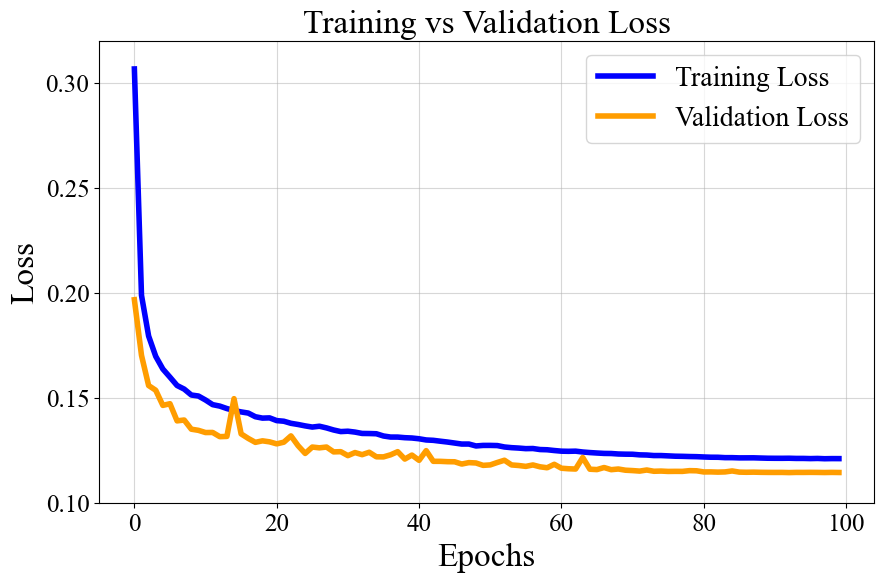

In [11]:
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=4, color='blue')
plt.plot(val_losses, label='Validation Loss', linewidth=4, color='#FF9D00')

plt.xlabel('Epochs', fontsize=24, fontname='Times New Roman')
plt.ylabel('Loss', fontsize=24, fontname='Times New Roman')
plt.title('Training vs Validation Loss', fontsize=24, fontname='Times New Roman')

tick_positions = [0.10, 0.15, 0.20, 0.25, 0.30]
tick_labels = ['0.10', '0.15', '0.20', '0.25', '0.30']
plt.yticks(tick_positions, tick_labels, fontsize=18, fontname='Times New Roman')

plt.xticks(fontsize=18, fontname='Times New Roman')
plt.yticks(fontsize=18, fontname='Times New Roman')
plt.ylim([0.1,0.32])

plt.legend(prop={'family': 'Times New Roman', 'size': 20})
plt.grid(True, alpha=0.5)
plt.savefig("train_val_curves.png", dpi=360, bbox_inches='tight')
plt.show()